# HDG for Poisson problem
## Numerical experiments for the conditioning

Consider the Posson problem on $\Omega\subseteq\mathbb R^{d}$, $d=2,3$.

\begin{equation*}
\begin{array}{rclll}
-\Delta u &=& f&\mbox{in}&\Omega \\
u &=& u_D& \mbox{on}& \partial \Omega
\end{array}
\end{equation*}

In [40]:
from ngsolve import *
from netgen.geom2d import unit_square 
from ngsolve.webgui import Draw 
from ngsolve.la import EigenValues_Preconditioner
import scipy.sparse as sp
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(precision=3)

In [12]:
def SetUp_HDG(mesh, p, db, condense=False):
    Vh = VectorL2(mesh, order=p)
    Wh = L2(mesh, order=p)
    Mh = FacetFESpace(mesh, order=p, dirichlet=db)
    fes = FESpace([Vh,Wh,Mh])
    qh, uh, uhat = fes.TrialFunction()
    vh, wh, what = fes.TestFunction()
    tau = 1.0 # stabilization parameter
    n = specialcf.normal(mesh.dim) # normal vector
    # HDG numerical flux
    qhatn = qh*n+tau*(uh-uhat)

    # Bilinear form
    a = BilinearForm(fes, condense=condense)
    a += (qh*vh - uh*div(vh))*dx +  (uhat*vh*n)*dx(element_boundary=True)
    a += (-div(qh)*wh*dx - tau*(uh-uhat)*wh*dx(element_boundary=True))
    a += qhatn*what*dx(element_boundary=True)
    a.Assemble()
    
    return a, fes

def SolvePoisson_HDG(mesh, p, force, uD, db): # Dirichlet boundary conditions
    a, fes = SetUp_HDG(mesh, p, db, condense=False)
    # Right hand side
    vh, wh, what = fes.TestFunction()
    f = LinearForm(fes)
    f += (-force)*wh*dx
    f.Assemble()
    
    gf = GridFunction(fes)
    gf.components[2].Set(uD, BND)
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data += inv * r
    return gf
    

In [41]:
def get_kappa(mesh,p, db, condense):
    a, fes = SetUp_HDG(mesh, p, db, condense)
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    # restrict to freedof
    fd = list(fes.FreeDofs(condense))
    Afree = A[fd,:][:,fd]
    # Estimate condition number kappa
    lams_LM = eigsh(Afree, which='LM')[0]
    # print(p,lams_LM)
    lams_SM = eigsh(Afree, which='SM')[0]
    # print(p, lams_SM)
    lams = np.concatenate((np.abs(lams_LM), np.abs(lams_SM)))
    print(p, lams)
    kappa = max(lams)/min(lams)
    return kappa

In [66]:
def test_condition_number_fixmesh(mesh,db,condense=False, pmax=6):
    kappa=[]
    p = [i for i in range(2,pmax+1)]
    for pi in p:
        kappa.append(get_kappa(mesh, pi, db, condense))
    return p, kappa

# Two-dimensional problem

In [43]:
# Data
force2d = ((2*pi**2))*sin(pi*x)*sin(pi*y)
uD    = 0        
dirichlet_boundary2d='left|bottom|right|top'

In [44]:
# Fix h
h = 0.25
mesh2d = Mesh(unit_square.GenerateMesh(maxh=h))
# Draw(mesh)

In [45]:
gf = SolvePoisson_HDG(mesh2d, p=5,force=force2d, uD=uD, db=dirichlet_boundary2d)
# Draw(gf.components[0])

## Condition number - Two dimensional case

In [54]:
# p, kappa= test_condition_number_fixmesh(mesh,dirichlet_boundary,condense=False, pmax=6)
p_sc_2d, kappa_sc_2d= test_condition_number_fixmesh(mesh2d,dirichlet_boundary2d,condense=True, pmax=22)

2 [24.937 24.355 24.098 22.994 22.354 21.328  0.897  0.843  0.778  0.661
  0.631  0.325]
3 [31.97  31.24  30.83  29.624 28.903 27.514  0.902  0.847  0.782  0.664
  0.634  0.325]
4 [38.252 37.448 36.91  35.261 34.415 32.875  0.903  0.847  0.783  0.664
  0.634  0.326]
5 [44.968 44.036 43.303 41.463 40.46  38.631  0.903  0.847  0.783  0.665
  0.634  0.326]
6 [51.363 50.344 49.435 47.248 46.087 44.075  0.903  0.847  0.783  0.665
  0.634  0.326]
7 [57.979 56.838 55.73  53.319 51.959 49.711  0.903  0.848  0.783  0.665
  0.634  0.326]
8 [64.429 63.191 61.891 59.171 57.613 55.181  0.903  0.848  0.783  0.665
  0.635  0.326]
9 [71.015 69.656 68.156 65.2   63.414 60.772  0.903  0.848  0.783  0.665
  0.635  0.326]
10 [77.5   76.04  74.34  71.095 69.084 66.26   0.903  0.848  0.783  0.665
  0.635  0.326]
11 [84.077 82.496 80.597 77.108 74.85  71.833  0.903  0.848  0.783  0.665
  0.635  0.326]
12 [90.587 88.901 86.8   83.033 80.532 77.337  0.903  0.848  0.783  0.665
  0.635  0.326]
13 [97.162 95.356 

In [49]:
# print(p, kappa)
print(p_sc, kappa_sc)

[2, 3, 4, 5, 6, 7, 8, 9] [76.72704357189953, 98.23220270144753, 117.49998691294395, 138.1155182016837, 157.749105182583, 178.06468675315804, 197.86949904960258, 218.09390180499958]


[76.72704357189953, 192.746476393407, 306.9081742875981, 413.6623523328158, 512.6924936706245, 604.7043721248076, 690.5433921470957, 770.985905573628]


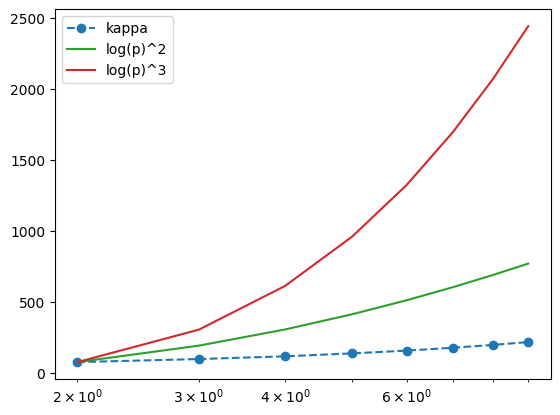

['-', 0.5364761481493107, 0.7700540785344812, 1.0830914891592953, 1.2385759392925761, 1.4678120072382912, 1.5889939400707875, 1.766346564362246]


In [58]:
import matplotlib.pyplot as plt

plt.semilogx(p_sc, kappa_sc,'--o',label='kappa')
C2 = kappa_sc[0]/(np.log(p_sc[0])*np.log(p_sc[0]))
p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p_sc]
print(p2)
plt.semilogx(p_sc, p2,'C02', label='log(p)^2')
C3 = kappa_sc[0]/(np.log(p_sc[0])*np.log(p_sc[0])*np.log(p_sc[0]))
p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p_sc]
plt.semilogx(p_sc, p3,'C03', label='log(p)^3')
plt.legend()
plt.savefig('kappa_HDG_2d.png')
plt.show()
gamma2d = compute_gamma(kappa_sc, p_sc)
print(gamma2d)

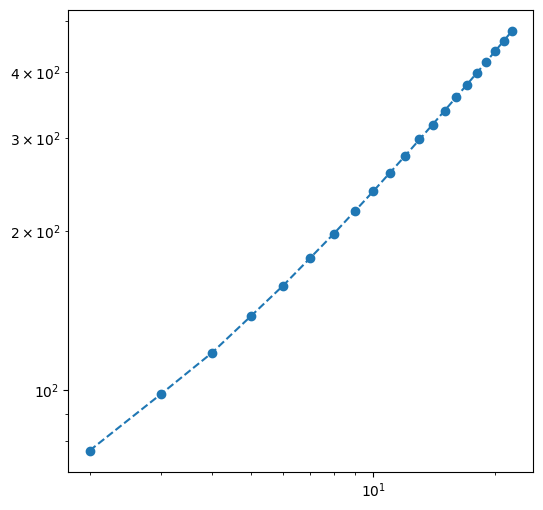

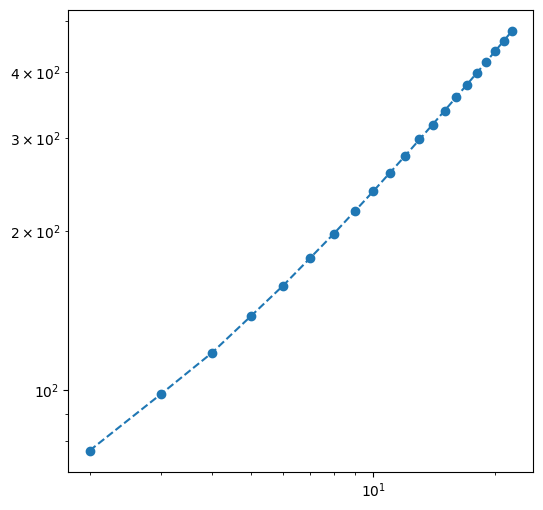

In [62]:

def plot_loglog(p,kappa,file='None'):
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.loglog(p,kappa,'--o',label='kappa')

    ax.loglog(p[]
    if file is not None:
        plt.savefig(file)
    plt.show()

plot_loglog(p_sc_2d,kappa_sc_2d)

# 3D problem

In [26]:
from netgen.csg import *

In [67]:
# Data
force3d = ((3*pi**2))*sin(pi*x)*sin(pi*y)*sin(pi*z)
uD    = 0        
dirichlet_boundary3d='back|left|front|right|bottom|top'

In [68]:
# Fix h
h = 0.5
mesh3d = Mesh(unit_cube.GenerateMesh(maxh=h))
# print(mesh.GetBoundaries())
# Draw(mesh)

In [65]:
gf = SolvePoisson_HDG(mesh3d, p=5,force=force3d, uD=uD, db=dirichlet_boundary3d)
# Draw(gf.components[1])

In [69]:
p_sc_3d, kappa_sc_3d= test_condition_number_fixmesh(mesh3d, dirichlet_boundary3d,condense=True, pmax=10)


2 [12.276 12.103 11.875 11.836 11.689 11.205  0.197  0.192  0.176  0.164
  0.153  0.113]
3 [15.252 14.906 14.605 14.51  14.152 13.715  0.132  0.125  0.116  0.112
  0.104  0.098]
4 [18.951 18.461 18.034 17.916 17.366 16.872  0.103  0.097  0.093  0.087
  0.083  0.077]
5 [21.968 21.327 20.896 20.47  19.659 19.222  0.086  0.083  0.076  0.07
  0.067  0.062]
6 [25.505 24.699 24.192 23.641 22.575 22.127  0.073  0.07   0.064  0.059
  0.056  0.052]
7 [28.594 27.66  27.22  26.244 24.816 24.408  0.062  0.06   0.055  0.051
  0.048  0.044]
8 [32.062 30.957 30.489 29.295 27.546 27.144  0.054  0.053  0.048  0.045
  0.042  0.039]
9 [3.521e+01 3.399e+01 3.364e+01 3.197e+01 2.977e+01 2.938e+01 4.743e-02
 4.720e-02 4.266e-02 3.969e-02 3.744e-02 3.464e-02]
10 [3.865e+01 3.726e+01 3.691e+01 3.495e+01 3.237e+01 3.200e+01 4.256e-02
 4.223e-02 3.843e-02 3.577e-02 3.369e-02 3.118e-02]


[108.24071122153329, 271.91215403362304, 432.96284488613315, 583.563566868291, 723.2678019301921, 853.0712024141068, 974.1664009937995, 1087.6486161344922, 1194.4585748815605] [108.24071122153329, 155.6874001224998, 246.3730929986246, 354.5226237256853, 492.3599643126171, 642.9270192072473, 823.1566092960842, 1016.6126774889435, 1239.4810974362697]


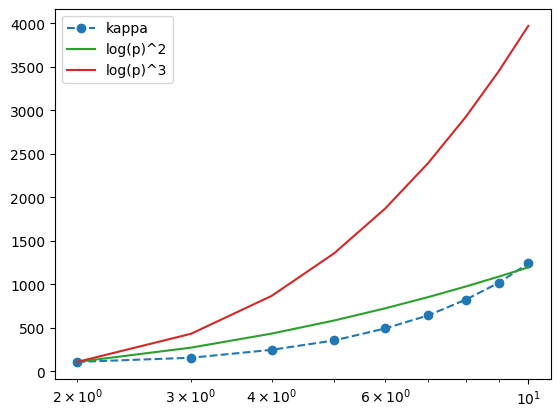

In [70]:
import matplotlib.pyplot as plt

plt.semilogx(p_sc_3d, kappa_sc_3d,'--o',label='kappa')

C2 = kappa_sc_3d[0]/(np.log(p_sc_3d[0])*np.log(p_sc_3d[0]))
p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p_sc_3d]
print(p2, kappa_sc_3d)
plt.semilogx(p_sc_3d, p2,'C02', label='log(p)^2')

C3 = kappa_sc_3d[0]/(np.log(p_sc_3d[0])*np.log(p_sc_3d[0])*np.log(p_sc_3d[0]))
p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p_sc_3d]
plt.semilogx(p_sc_3d, p3,'C03', label='log(p)^3')
plt.legend()
plt.savefig('kappa_HDG_3d.png')
plt.show()

In [71]:
def compute_gamma(kappa, p):
    # Adjust \kappa  = O(\log(p)^\gamma)
    gamma = [0.0]
    for i in range(len(p)-1):
        gamma.append(np.log(kappa[i+1]/kappa[i])/np.log(np.log(p[i+1])/np.log(p[i])))
    return gamma

def compute_alpha(kappa, p):
    # Adjust \kappa = O(p^\alpha)
    alpha = [0.0]
    for i in range(len(p)-1):
        alpha.append(np.log(kappa[i+1]/kappa[i])/np.log((p[i+1])/(p[i])))
    return alpha
    

In [72]:
gamma2d = compute_gamma(kappa_sc_2d, p_sc_2d)
alpha2d = compute_alpha(kappa_sc_2d, p_sc_2d)

In [73]:
gamma3d = compute_gamma(kappa_sc_3d, p_sc_3d)
alpha3d = compute_alpha(kappa_sc_3d, p_sc_3d)

# Tables

In [74]:
df_2d = pd.DataFrame({'p':p_sc_2d, 'kappa':kappa_sc_2d, 'log(p)':np.log(p_sc_2d), 'gamma':gamma2d, 'alpha':alpha2d})
df_2d

,p,kappa,log(p),gamma,alpha
0,2,76.727044,0.693147,-,-
1,3,98.232203,1.098612,0.536476,0.609374
2,4,117.499987,1.386294,0.770054,0.622577
3,5,138.115518,1.609438,1.083091,0.724431
4,6,157.749105,1.791759,1.238576,0.729016
5,7,178.064687,1.945910,1.467812,0.785861
6,8,197.869499,2.079442,1.588994,0.789783
7,9,218.093902,2.197225,1.766347,0.826248
8,10,238.009213,2.302585,1.86568,0.829378
9,11,258.206104,2.397895,2.008157,0.854565


In [75]:
df_3d = pd.DataFrame({'p':p_sc_3d, 'kappa':kappa_sc_3d, 'log(p)':np.log(p_sc_3d), 'gamma':gamma3d, 'alpha':alpha3d})
df_3d

,p,kappa,log(p),gamma,alpha
0,2,108.240711,0.693147,-,-
1,3,155.687400,1.098612,0.789239,0.896483
2,4,246.373093,1.386294,1.973446,1.5955
3,5,354.522624,1.609438,2.438347,1.630901
4,6,492.359964,1.791759,3.060558,1.801421
5,7,642.927019,1.945910,3.232952,1.730911
6,8,823.156609,2.079442,3.723322,1.850615
7,9,1016.612677,2.197225,3.831247,1.792151
8,10,1239.481097,2.302585,4.232013,1.881318


In [122]:
# !pip install tabulate
from tabulate import tabulate

def dataframe_to_latex(df, filename=None, col_round=None):
    """
    Print and save a DataFrame as a LaTeX table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.
    filename (str): The name of the file to save the LaTeX table to.
    """
    
    if col_round is not None:
        df_rounded = df.copy()
        
        for columns, precision in col_round:
            df_rounded[columns]
            print(columns, precision)
            df_rounded[columns] = df_rounded[columns].round(precision)
    # Convert DataFrame to LaTeX table string
    latex_table = tabulate(df_rounded, headers='keys', tablefmt='latex', showindex=False)

    # Print the LaTeX table
    print(latex_table)

    # Save the LaTeX table to a file
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(latex_table)

    

In [123]:
df_2d.dtypes

p           int64
kappa     float64
log(p)    float64
gamma     float64
alpha     float64
dtype: object

In [127]:

df_2d['gamma']=df_2d['gamma'].astype('float')
df_2d['alpha']=df_2d['alpha'].astype('float')
df_2d.dtypes
df_2d['gamma'].round(3)
print(df_2d['gamma'])
# df_2d['gamma'][0] = 0.0
# df_2d['alpha'][0] = 0.0
dataframe_to_latex(df_2d,filename='table_HDG2d_kappa', col_round=[['kappa',1],['log(p)', 3],['gamma',3],['alpha',3]])

0     1.123453
1     0.536476
2     0.770054
3     1.083091
4     1.238576
5     1.467812
6     1.588994
7     1.766347
8     1.865680
9     2.008157
10    2.092260
11    2.210133
12    2.282950
13    2.382776
14    2.446902
15    2.533053
16    2.590289
17    2.665794
18    2.717442
19    2.784469
20    2.831498
Name: gamma, dtype: float64
kappa 1
log(p) 3
gamma 3
alpha 3
\begin{tabular}{rrrrr}
\hline
   p &   kappa &   log(p) &   gamma &   alpha \\
\hline
   2 &    76.7 &    0.693 &   1.123 &   0     \\
   3 &    98.2 &    1.099 &   0.536 &   0.609 \\
   4 &   117.5 &    1.386 &   0.77  &   0.623 \\
   5 &   138.1 &    1.609 &   1.083 &   0.724 \\
   6 &   157.7 &    1.792 &   1.239 &   0.729 \\
   7 &   178.1 &    1.946 &   1.468 &   0.786 \\
   8 &   197.9 &    2.079 &   1.589 &   0.79  \\
   9 &   218.1 &    2.197 &   1.766 &   0.826 \\
  10 &   238   &    2.303 &   1.866 &   0.829 \\
  11 &   258.2 &    2.398 &   2.008 &   0.855 \\
  12 &   278.2 &    2.485 &   2.092 &   0.857 \\

In [130]:
df_3d['gamma'][0] = 0.0
df_3d['alpha'][0] = 0.0
df_3d['gamma']=df_3d['gamma'].astype('float')
df_3d['alpha']=df_3d['alpha'].astype('float')
dataframe_to_latex(df_3d,filename='table_HDG3d_kappa',col_round=[['kappa',1],['log(p)', 3],['gamma',3],['alpha',3]] )

kappa 1
log(p) 3
gamma 3
alpha 3
\begin{tabular}{rrrrr}
\hline
   p &   kappa &   log(p) &   gamma &   alpha \\
\hline
   2 &   108.2 &    0.693 &   0     &   0     \\
   3 &   155.7 &    1.099 &   0.789 &   0.896 \\
   4 &   246.4 &    1.386 &   1.973 &   1.596 \\
   5 &   354.5 &    1.609 &   2.438 &   1.631 \\
   6 &   492.4 &    1.792 &   3.061 &   1.801 \\
   7 &   642.9 &    1.946 &   3.233 &   1.731 \\
   8 &   823.2 &    2.079 &   3.723 &   1.851 \\
   9 &  1016.6 &    2.197 &   3.831 &   1.792 \\
  10 &  1239.5 &    2.303 &   4.232 &   1.881 \\
\hline
\end{tabular}


<ipython-input-130-f0a410f1752d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3d['gamma'][0] = 0.0
<ipython-input-130-f0a410f1752d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3d['alpha'][0] = 0.0


In [105]:
# Create a sample DataFrame
data = {
    'Column1': [1.123456, 2.123456, 3.123456],
    'Column2': [4.123456, 5.123456, 6.123456],
    'Column3': [7.123456, 8.123456, 9.123456]
}
df = pd.DataFrame(data)

# Round 'Column1' to 3 decimal places
print(df['Column1'].dtype())
df['Column1'] = df['Column1'].round(3)

print(df)

TypeError: 'numpy.dtype[float64]' object is not callable